In [213]:
import pandas as pd
import matplotlib.pyplot as plt  ## for plotting graph
import numpy as np   ## for numerical operation
import seaborn as sns ## for enhanced visualizations
from scipy.stats import mannwhitneyu, chi2_contingency, norm, skew  # For statistical tests
from statsmodels.stats.proportion import proportion_confint  # For proportion confidence intervals


In [165]:
# Set seaborn style
sns.set(style="whitegrid")

In [214]:
# --- Data Loading ---
# Load datasets: dataset1.csv (individual bat landings) and dataset2.csv (30-minute aggregated observations)
dataset1 = pd.read_csv('dataset1.csv')
dataset2 = pd.read_csv('dataset2.csv')

In [215]:
print(dataset1.head())

##show all column
pd.set_option('display.max_columns', None)
#df.

         start_time  bat_landing_to_food habit  rat_period_start  \
0  30/12/2017 18:37            16.000000   rat  30/12/2017 18:35   
1  30/12/2017 19:51             0.074016  fast  30/12/2017 19:50   
2  30/12/2017 19:51             4.000000  fast  30/12/2017 19:50   
3  30/12/2017 19:52            10.000000   rat  30/12/2017 19:50   
4  30/12/2017 19:54            15.000000   rat  30/12/2017 19:50   

     rat_period_end  seconds_after_rat_arrival  risk  reward  month  \
0  30/12/2017 18:38                        108     1       0      0   
1  30/12/2017 19:55                         17     0       1      0   
2  30/12/2017 19:55                         41     0       1      0   
3  30/12/2017 19:55                        111     1       0      0   
4  30/12/2017 19:55                        194     1       0      0   

        sunset_time  hours_after_sunset  season  
0  30/12/2017 16:45            1.870833       0  
1  30/12/2017 16:45            3.100833       0  
2  30/12/2017 

In [216]:
### Data Exploration Step for dat set 1
###############################
## check for missing Value,
##  Garbage/Invalid data 
## Distribution, Correlations, onte outlines

print("\n Dataset Inofromattion")
dataset1.info()   ## show data type and missing vlaue

print("\n Statistiacal Summary ")
print(dataset1.describe())  ## provides Summary stats

print("\nMissing Values:")
print(dataset1.isnull().sum())




 Dataset Inofromattion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   start_time                 907 non-null    object 
 1   bat_landing_to_food        907 non-null    float64
 2   habit                      866 non-null    object 
 3   rat_period_start           907 non-null    object 
 4   rat_period_end             907 non-null    object 
 5   seconds_after_rat_arrival  907 non-null    int64  
 6   risk                       907 non-null    int64  
 7   reward                     907 non-null    int64  
 8   month                      907 non-null    int64  
 9   sunset_time                907 non-null    object 
 10  hours_after_sunset         907 non-null    float64
 11  season                     907 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 85.2+ KB

 Statistiacal Summary 


In [218]:
### Data Exploration Step for dat set 2
###############################
## check for missing Value,
##  Garbage/Invalid data 
## Distribution, Correlations, onte outlines

print("\n Dataset Inofromattion")
dataset2.info()   ## show data type and missing vlaue

print("\n Statistiacal Summary ")
print(dataset2.describe())  ## provides Summary stats

print("\nMissing Values:")
print(dataset2.isnull().sum())



 Dataset Inofromattion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                2123 non-null   object 
 1   month               2123 non-null   int64  
 2   hours_after_sunset  2123 non-null   float64
 3   bat_landing_number  2123 non-null   int64  
 4   food_availability   2123 non-null   float64
 5   rat_minutes         2123 non-null   float64
 6   rat_arrival_number  2123 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 116.2+ KB

 Statistiacal Summary 
             month  hours_after_sunset  bat_landing_number  food_availability  \
count  2123.000000         2123.000000         2123.000000        2123.000000   
mean      3.083844            5.265426           32.083373           2.445874   
std       1.642261            4.076188           25.614431           1.218353   
min       0.00000

In [220]:
print(dataset1.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['start_time', 'bat_landing_to_food', 'habit', 'rat_period_start',
       'rat_period_end', 'seconds_after_rat_arrival', 'risk', 'reward',
       'month', 'sunset_time', 'hours_after_sunset', 'season'],
      dtype='object')>


In [221]:
print(dataset2.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['time', 'month', 'hours_after_sunset', 'bat_landing_number',
       'food_availability', 'rat_minutes', 'rat_arrival_number'],
      dtype='object')>


In [222]:
## Data Preprocessing
## check for any duplicate vaules in dataset 
print(f'There are {dataset1.duplicated().sum()} duplicate rows in dataset 1.')
print(f'There are {dataset2.duplicated().sum()} duplicate rows in dataset 2.')

There are 1 duplicate rows in dataset 1.
There are 0 duplicate rows in dataset 2.


In [223]:
# 4. Remove Duplicates
# Remove duplicate rows to avoid double-counting events or periods
dataset1 = dataset1.drop_duplicates()
dataset2 = dataset2.drop_duplicates()

In [224]:
### 41 data are missing form habit column
# 1. Handle Missing Values
# Check and address missing values in quantitative and qualitative variables to ensure data completeness
# Quantitative (dataset1): bat_landing_to_food, seconds_after_rat_arrival, hours_after_sunset
for col in ['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset']:
    if dataset1[col].isnull().sum() > 0:
        print(f"Missing values in dataset1.{col}: {dataset1[col].isnull().sum()}")
        if col == 'bat_landing_to_food':
            # Drop rows with missing bat_landing_to_food, as it's critical for vigilance analysis
            dataset1 = dataset1.dropna(subset=[col])
        elif col == 'seconds_after_rat_arrival':
            # Missing seconds_after_rat_arrival indicates no rat was present; leave as is
            pass
        elif col == 'hours_after_sunset':
            # Impute with median of same month to preserve temporal patterns
            dataset1[col] = dataset1.groupby('month')[col].transform(lambda x: x.fillna(x.median()))



In [225]:
## checking for any messing  value data set 1
print(dataset1.isna().sum())

start_time                    0
bat_landing_to_food           0
habit                        41
rat_period_start              0
rat_period_end                0
seconds_after_rat_arrival     0
risk                          0
reward                        0
month                         0
sunset_time                   0
hours_after_sunset            0
season                        0
dtype: int64


## habit is missing 41  column data
The bellow code focuses on identifying and addressing missing values in these columns, with specific handling for the habit column (imputing with 'unknown') and different handling for risk and reward (dropping rows). It also includes diagnostic checks to explore whether missing habit values are related to key variables like bat_landing_to_food or rat presence (seconds_after_rat_arrival).

In [226]:
# Qualitative (dataset1): risk, reward, habit
for col in ['risk', 'reward', 'habit']:
    if col in dataset1.columns and dataset1[col].isnull().sum() > 0:
        print(f"Missing values in dataset1.{col}: {dataset1[col].isnull().sum()}")
        if col == 'habit':
            # Impute missing habit with 'unknown'
            print(f"Imputing {dataset1[col].isnull().sum()} missing habit values with 'unknown'")
            dataset1[col] = dataset1[col].fillna('unknown')
            # Diagnostic: Check if missing habit correlates with rat presence or bat_landing_to_food
            missing_habit = dataset1[dataset1[col].isna()]  # Before imputation
            if not missing_habit.empty:
                print("Descriptive stats for bat_landing_to_food in rows with missing habit:")
                print(missing_habit['bat_landing_to_food'].describe())
                print("Rat presence in rows with missing habit:")
                print(missing_habit['seconds_after_rat_arrival'].notnull().value_counts())
        else:
            # Drop rows with missing risk or reward
            dataset1 = dataset1.dropna(subset=[col])

Missing values in dataset1.habit: 41
Imputing 41 missing habit values with 'unknown'


In [227]:
# Quantitative (dataset2): bat_landing_number, food_availability, rat_minutes, rat_arrival_number, hours_after_sunset
for col in ['bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'hours_after_sunset']:
    if dataset2[col].isnull().sum() > 0:
        print(f"Missing values in dataset2.{col}: {dataset2[col].isnull().sum()}")
        if col == 'food_availability':
            # Impute with median of same month to account for seasonal patterns
            dataset2[col] = dataset2.groupby('month')[col].transform(lambda x: x.fillna(x.median()))
        elif col in ['rat_minutes', 'rat_arrival_number']:
            # Assume 0 for missing rat presence (no rats in that period)
            dataset2[col] = dataset2[col].fillna(0)
        else:
            # Drop rows with missing bat_landing_number or hours_after_sunset
            dataset2 = dataset2.dropna(subset=[col])

In [228]:
## checking for any messing  value data set 2
print(dataset2.isna().sum())

time                  0
month                 0
hours_after_sunset    0
bat_landing_number    0
food_availability     0
rat_minutes           0
rat_arrival_number    0
dtype: int64


In [230]:
# 2. Correct Data Types
# Ensure columns have appropriate types for analysis and merging
time_cols_dataset1 = ["start_time", "rat_period_start", "rat_period_end", "sunset_time"]
try:
    # Convert time columns to datetime for temporal alignment
    for col in time_cols_dataset1:
        dataset1[col] = pd.to_datetime(dataset1[col], errors="coerce")

    dataset2['time'] = pd.to_datetime(dataset2['time'], errors='coerce')
except Exception as e:
    print(f"Error converting datetime: {e}")


In [231]:
# Convert numeric columns to float/int, handling invalid entries
numeric_cols_d1 = ['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset']
numeric_cols_d2 = ['bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'hours_after_sunset']
for col in numeric_cols_d1:
    dataset1[col] = pd.to_numeric(dataset1[col], errors='coerce')
for col in numeric_cols_d2:
    dataset2[col] = pd.to_numeric(dataset2[col], errors='coerce')


In [232]:
# Ensure binary (risk, reward) and categorical (habit) columns are correctly formatted
dataset1['risk'] = dataset1['risk'].astype(int, errors='ignore')
dataset1['reward'] = dataset1['reward'].astype(int, errors='ignore')
dataset1['habit'] = dataset1['habit'].astype(str).str.lower()  # Standardize to lowercase for consistency

In [233]:
print(numeric_cols_d1)
print(numeric_cols_d2)

['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset']
['bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'hours_after_sunset']


#### Outlier capping 
The outlier capping process is a data preprocessing technique used to handle extreme values (outliers) in a dataset by limiting them to a specified range, rather than removing them. Outliers are data points that significantly deviate from the rest of the data and can skew statistical analyses, visualizations, or machine learning models

## The code uses the IQR method to detect and cap outliers:

## IQR Calculation:

IQR = Q3 (75th percentile) - Q1 (25th percentile).
Lower bound = Q1 - 1.5 * IQR.
Upper bound = Q3 + 1.5 * IQR.

## Capping: Values below the lower bound are set to the lower bound, and values above the upper bound are set to the upper bound.

In [234]:
# --- Outlier Capping Function ---
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

In [235]:
# Apply outlier capping to quantitative columns (except seconds_after_rat_arrival, which is context-specific)
for col in numeric_cols_d1:
    if col != 'seconds_after_rat_arrival':
        print(f"\nBefore capping ({col}):")
        print(dataset1[col].describe())     # summary stats before
        dataset1 = cap_outliers(dataset1, col)

        print(f"After capping ({col}):")
        print(dataset1[col].describe())     # summary stats after


for col in numeric_cols_d2:

    print(f"\nBefore capping ({col}):")
    print(dataset2[col].describe())         # summary stats before

    dataset2 = cap_outliers(dataset2, col)
    print(f"After capping ({col}):")
    print(dataset2[col].describe())         # summary stats aft



Before capping (bat_landing_to_food):
count    906.000000
mean      11.720544
std       27.658777
min        0.010238
25%        1.000000
50%        4.000000
75%       11.750000
max      443.000000
Name: bat_landing_to_food, dtype: float64
After capping (bat_landing_to_food):
count    906.000000
mean       7.849683
std        9.007693
min        0.010238
25%        1.000000
50%        4.000000
75%       11.750000
max       27.875000
Name: bat_landing_to_food, dtype: float64

Before capping (hours_after_sunset):
count    906.000000
mean       5.532579
std        2.415383
min       -0.261667
25%        3.775069
50%        5.627083
75%        7.406250
max       12.091944
Name: hours_after_sunset, dtype: float64
After capping (hours_after_sunset):
count    906.000000
mean       5.532579
std        2.415383
min       -0.261667
25%        3.775069
50%        5.627083
75%        7.406250
max       12.091944
Name: hours_after_sunset, dtype: float64

Before capping (bat_landing_number):
count 

##
### in above outlier capping to quantitative columns
## in dataset 1 
  # bat_landing_to_food
   count : 907, Mean : 7.79 Seconds, Std: 8.87 secondss, Min : 0.01 Seconds, Q1(25%) : 1:00 seconds
   Q2(50%) : 4.00 seconds, Q3(75%) : 11.50 seconds

   no change in befor and after Capping beacuse 
   IQR = 11.50 - 1.00 = 10.50 seconds.
   Lower bound = 1.00 - 1.5 * 10.50 = -14.75 seconds = 0.01 (since negative times are not possible)
   Upper bound = 11.50 + 1.5 * 10.50 = 27.25 seconds
   All values are within [0.01, 27.25], so no capping occurred.

   ## hours_after_sunset 
      no change in befor and after Capping beacuse 

## in dataset 2
  # bat_landing_number
  no change in befor and after Capping beacuse 
 
 # food_availability
  no change in befor and after Capping beacuse 

# rat_minutes
 no change in befor and after Capping beacuse
# rat_arrival_number
 no change in befor and after Capping beacuse
 # hours_after_sunset
 no change in befor and after Capping beacuse


## Vlidate Temporal Consistency
 This following specific section focuses on validating the temporal consistency of the seconds_after_rat_arrival column in dataset1.csv by ensuring it aligns with the rat_period_start and rat_period_end columns. If inconsistencies are found, the code identifies and removes the affected rows to maintain data integrity.

In [237]:
## preprocessing step
# 5. Validate Temporal Consistency
# Ensure seconds_after_rat_arrival aligns with rat_period_start and rat_period_end
dataset1['rat_period_start'] = pd.to_datetime(dataset1['rat_period_start'], errors='coerce')
dataset1['rat_period_end'] = pd.to_datetime(dataset1['rat_period_end'], errors='coerce')
invalid_time = dataset1[
    (dataset1['seconds_after_rat_arrival'].notnull()) &
    (~dataset1['start_time'].between(dataset1['rat_period_start'], dataset1['rat_period_end']))
]
if not invalid_time.empty:
    print(f"Found {len(invalid_time)} inconsistent time entries; dropping them.")
    dataset1 = dataset1.drop(invalid_time.index)


In [238]:

# 6. Standardize habit categories
# Fix known inconsistencies in habit (e.g., typos or case variations)
dataset1['habit'] = dataset1['habit'].replace({'Fast': 'fast', 'Pick': 'pick'})

In [239]:
print("\n Data set 1 information ")
print("\n =====================dataset 1 ===========================")
dataset1.info()
print("\n Data set 2 information ")
print("\n =====================dataset 2 ===========================")
dataset2.info()


 Data set 1 information 

 =====================dataset 1 ===========================
<class 'pandas.core.frame.DataFrame'>
Index: 906 entries, 0 to 906
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   start_time                 906 non-null    datetime64[ns]
 1   bat_landing_to_food        906 non-null    float64       
 2   habit                      906 non-null    object        
 3   rat_period_start           906 non-null    datetime64[ns]
 4   rat_period_end             906 non-null    datetime64[ns]
 5   seconds_after_rat_arrival  906 non-null    int64         
 6   risk                       906 non-null    int64         
 7   reward                     906 non-null    int64         
 8   month                      906 non-null    int64         
 9   sunset_time                906 non-null    datetime64[ns]
 10  hours_after_sunset         906 non-null    float64  

In [240]:
# --- Merge on common keys ---
merged_data = pd.merge(
    dataset1,
    dataset2,
    on=["month", "hours_after_sunset"],  # shared keys
    how="left"  # keep all rows from dataset1
)

print("Shape after merge:", merged_data.shape)
print(merged_data.info())

# --- Handle missing values in food_availability ---
if merged_data['food_availability'].isnull().sum() > 0:
    print(f"Missing food_availability after merge: {merged_data['food_availability'].isnull().sum()}")
    merged_data['food_availability'] = (
        merged_data.groupby('month')['food_availability']
                   .transform(lambda x: x.fillna(x.median()))
    )

# ---  Handle other numeric missing values ---
for col in ['bat_landing_number','rat_minutes','rat_arrival_number']:
    if col in merged_data.columns:
        merged_data[col] = (
            merged_data.groupby('month')[col]
                       .transform(lambda x: x.fillna(x.median()))
        )

# --- Final check ---
print("\nAfter imputation:")
print(merged_data.isnull().sum())

Shape after merge: (925, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   start_time                 925 non-null    datetime64[ns]
 1   bat_landing_to_food        925 non-null    float64       
 2   habit                      925 non-null    object        
 3   rat_period_start           925 non-null    datetime64[ns]
 4   rat_period_end             925 non-null    datetime64[ns]
 5   seconds_after_rat_arrival  925 non-null    int64         
 6   risk                       925 non-null    int64         
 7   reward                     925 non-null    int64         
 8   month                      925 non-null    int64         
 9   sunset_time                925 non-null    datetime64[ns]
 10  hours_after_sunset         925 non-null    float64       
 11  season                     925 non-null   

In [241]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   start_time                 925 non-null    datetime64[ns]
 1   bat_landing_to_food        925 non-null    float64       
 2   habit                      925 non-null    object        
 3   rat_period_start           925 non-null    datetime64[ns]
 4   rat_period_end             925 non-null    datetime64[ns]
 5   seconds_after_rat_arrival  925 non-null    int64         
 6   risk                       925 non-null    int64         
 7   reward                     925 non-null    int64         
 8   month                      925 non-null    int64         
 9   sunset_time                925 non-null    datetime64[ns]
 10  hours_after_sunset         925 non-null    float64       
 11  season                     925 non-null    int64         
 12  time    

In [242]:
# Handle unmatched rows in merged_data (e.g., missing food_availability)

print("\n Before imputation:")
print(merged_data)

if merged_data['food_availability'].isnull().sum() > 0:
    print(f"Missing food_availability after merge: {merged_data['food_availability'].isnull().sum()}")
    merged_data['food_availability'] = merged_data.groupby('month')['food_availability'].transform(lambda x: x.fillna(x.median()))

print("\nAfter imputation:")
print(merged_data)


 Before imputation:
             start_time  bat_landing_to_food     habit    rat_period_start  \
0   2017-12-30 18:37:00            16.000000       rat 2017-12-30 18:35:00   
1   2017-12-30 19:51:00             0.074016      fast 2017-12-30 19:50:00   
2   2017-12-30 19:51:00             4.000000      fast 2017-12-30 19:50:00   
3   2017-12-30 19:52:00            10.000000       rat 2017-12-30 19:50:00   
4   2017-12-30 19:54:00            15.000000       rat 2017-12-30 19:50:00   
..                  ...                  ...       ...                 ...   
920 2018-05-04 04:18:00             2.000000       rat 2018-05-04 04:14:00   
921 2018-05-04 04:18:00             1.000000      fast 2018-05-04 04:14:00   
922 2018-05-04 04:19:00            22.000000      pick 2018-05-04 04:14:00   
923 2018-05-03 23:51:00             2.000000      fast 2018-05-03 23:46:00   
924 2018-05-04 05:39:00            27.875000  pick_rat 2018-05-04 05:37:00   

         rat_period_end  seconds_after_rat

In [243]:
# 8. Feature Engineering
# Create a binary rat_present column to simplify analysis (1 if rat was present, 0 otherwise)
merged_data['rat_present'] = merged_data['seconds_after_rat_arrival'].notnull() | (merged_data['rat_minutes'] > 0)

In [192]:
# Define rat-present and rat-absent groups for analysis
rat_present = merged_data[merged_data['rat_present']]
rat_absent = merged_data[~merged_data['rat_present']]


In [244]:
# --- Descriptive Analysis: Quantitative Variables ---
# Define quantitative variables to analyze from both datasets
quant_vars = {
    'dataset1': ['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset'],
    'dataset2': ['bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number']
   }



Descriptive Analysis for dataset1:

bat_landing_to_food:
  Mean: 7.69, Median: 4.00, Mode: 1.00
  Std Dev: 8.98, Range: 27.86, Variance: 80.69, IQR: 10.00
  Skewness: 1.24 (Right-skewed)


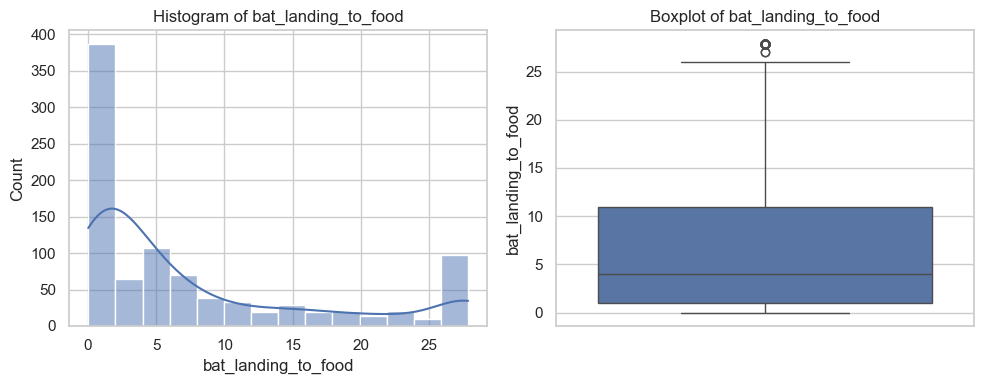


seconds_after_rat_arrival:
  Mean: 284.54, Median: 211.00, Mode: 368.00
  Std Dev: 238.91, Range: 949.00, Variance: 57076.64, IQR: 346.00
  Skewness: 0.90 (Right-skewed)


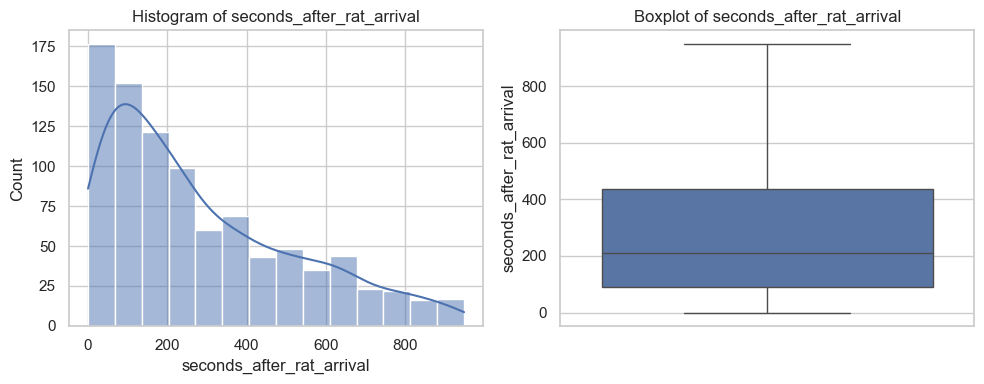


hours_after_sunset:
  Mean: 5.56, Median: 5.74, Mode: 7.00
  Std Dev: 2.40, Range: 12.35, Variance: 5.76, IQR: 3.58
  Skewness: -0.20 (Symmetric)


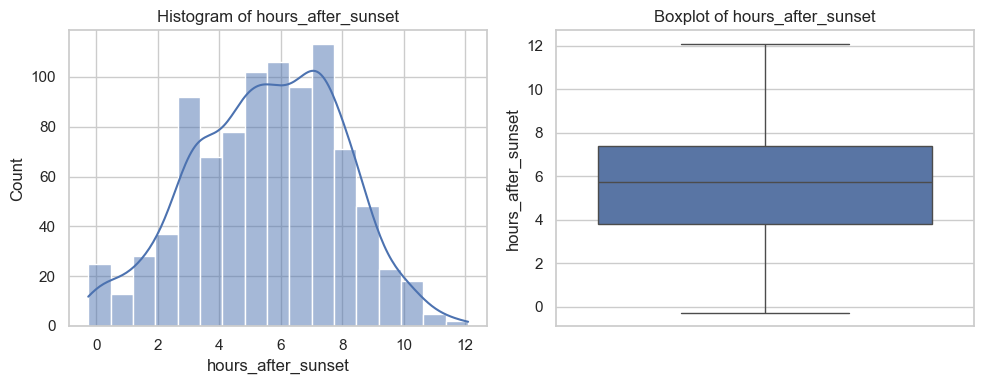


Descriptive Analysis for dataset2:

bat_landing_number:
  Mean: 31.88, Median: 27.00, Mode: 2.00
  Std Dev: 24.84, Range: 103.50, Variance: 617.10, IQR: 37.00
  Skewness: 0.81 (Right-skewed)


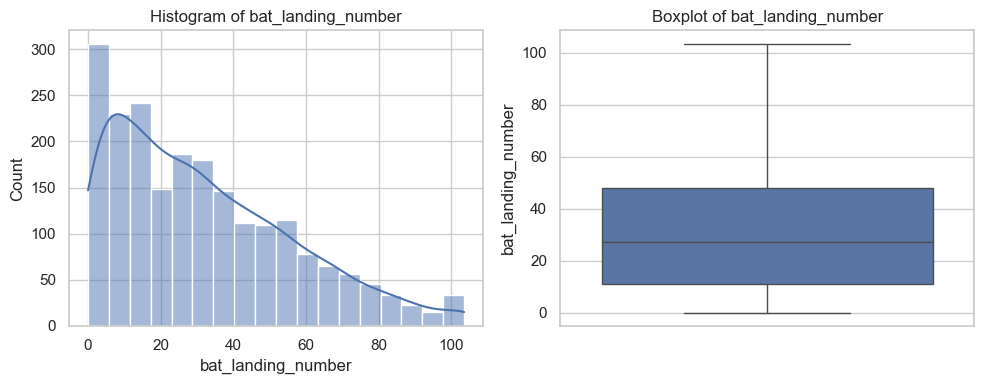


food_availability:
  Mean: 2.47, Median: 2.95, Mode: 3.00
  Std Dev: 1.17, Range: 3.75, Variance: 1.38, IQR: 1.14
  Skewness: -0.42 (Symmetric)


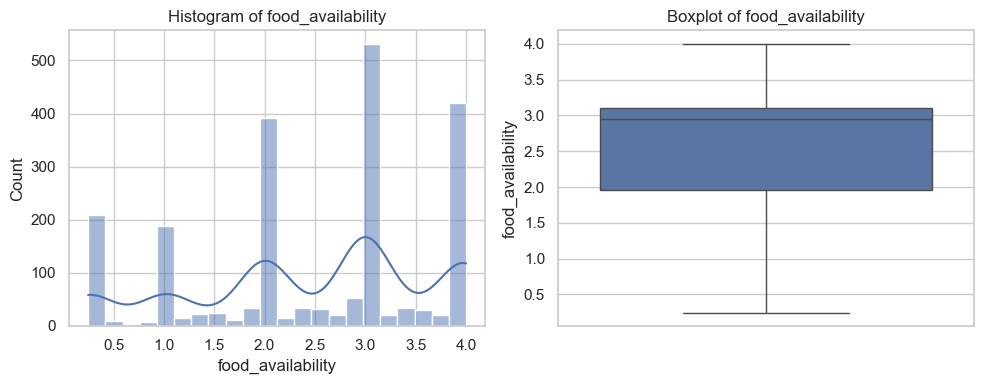


rat_minutes:
  Mean: 0.10, Median: 0.00, Mode: 0.00
  Std Dev: 0.17, Range: 0.40, Variance: 0.03, IQR: 0.16
  Skewness: 1.16 (Right-skewed)


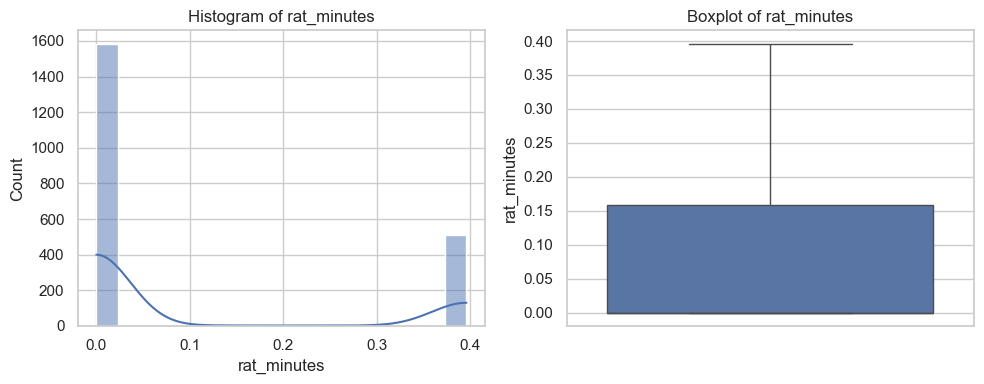


rat_arrival_number:
  Mean: 0.38, Median: 0.00, Mode: 0.00
  Std Dev: 0.71, Range: 2.50, Variance: 0.51, IQR: 1.00
  Skewness: 1.79 (Right-skewed)


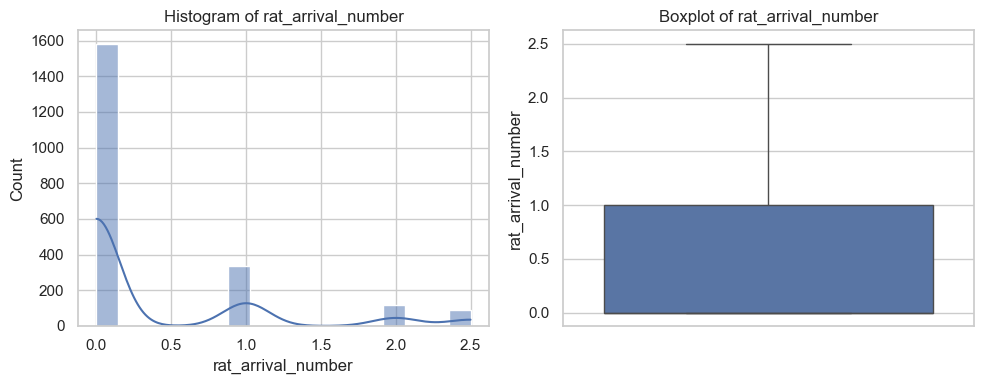

In [245]:
 ##Loop through datasets and variables to compute descriptive statistics
for dataset_name, vars_list in quant_vars.items():
    data = merged_data if dataset_name == 'dataset1' else dataset2
    print(f"\nDescriptive Analysis for {dataset_name}:")
    for var in vars_list:
        # Use rat_present for seconds_after_rat_arrival, as it's only relevant when rats are present
        if var == 'seconds_after_rat_arrival':
            values = rat_present[var].dropna()
        else:
            values = data[var].dropna()
        
        # Compute measures of center: mean, median, mode
        mean_val = values.mean()
        median_val = values.median()
        mode_val = values.mode()[0] if not values.mode().empty else np.nan
        
        # Compute dispersion: std, range, variance, IQR
        std_val = values.std()
        range_val = values.max() - values.min()
        variance_val = values.var()
        iqr_val = np.percentile(values, 75) - np.percentile(values, 25)
        
        # Compute shape: skewness to determine if symmetric, right-skewed, or left-skewed
        skewness = skew(values, nan_policy='omit')
        shape = 'Symmetric' if abs(skewness) < 0.5 else 'Right-skewed' if skewness > 0.5 else 'Left-skewed'
        
        # Print statistics for the variable
        print(f"\n{var}:")
        print(f"  Mean: {mean_val:.2f}, Median: {median_val:.2f}, Mode: {mode_val:.2f}")
        print(f"  Std Dev: {std_val:.2f}, Range: {range_val:.2f}, Variance: {variance_val:.2f}, IQR: {iqr_val:.2f}")
        print(f"  Skewness: {skewness:.2f} ({shape})")
        
        # Visualize distribution with histogram (with KDE) and boxplot
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(values, kde=True)
        plt.title(f'Histogram of {var}')
        plt.subplot(1, 2, 2)
        sns.boxplot(y=values)
        plt.title(f'Boxplot of {var}')
        plt.tight_layout()
        plt.show()





Frequency Table for risk:
risk
1    467
0    458
Name: count, dtype: int64


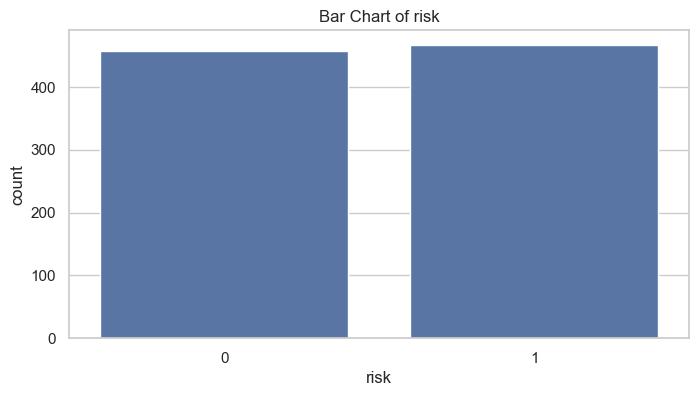

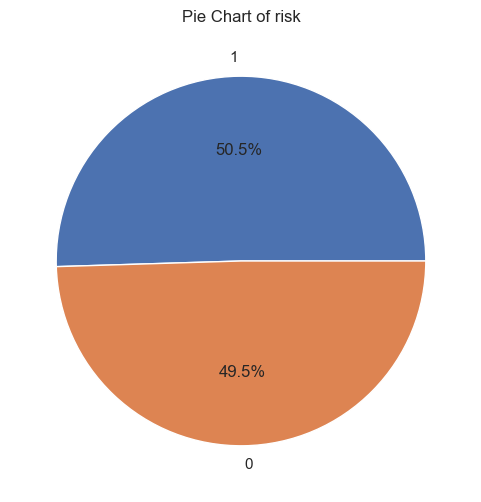


Frequency Table for reward:
reward
1    484
0    441
Name: count, dtype: int64


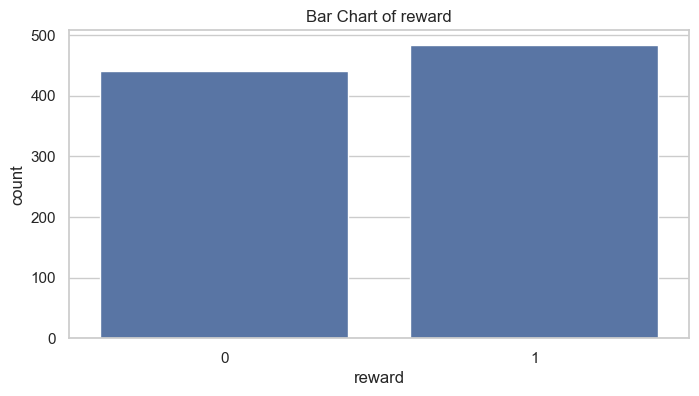

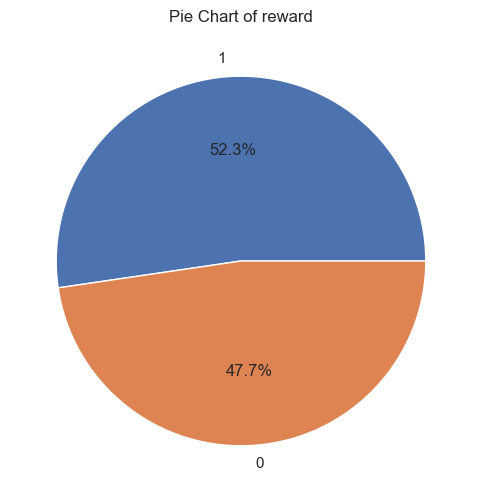


Frequency Table for habit:
habit
fast                                                245
rat                                                 240
pick                                                139
unknown                                              41
bat                                                  30
                                                   ... 
bat_fight_and_rat                                     1
rat_and_rat                                           1
not_sure_rat                                          1
501.0,358.4,636.2,423.4; 476.0,103.0,634.0,206.0      1
rat_and_bat_and_pick                                  1
Name: count, Length: 82, dtype: int64


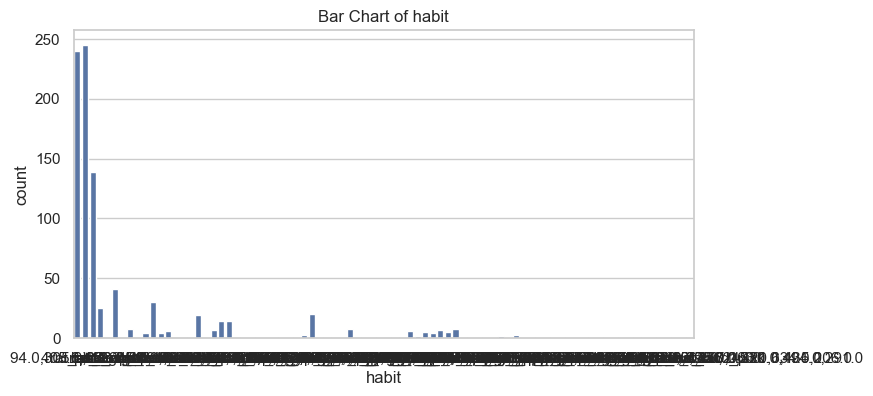

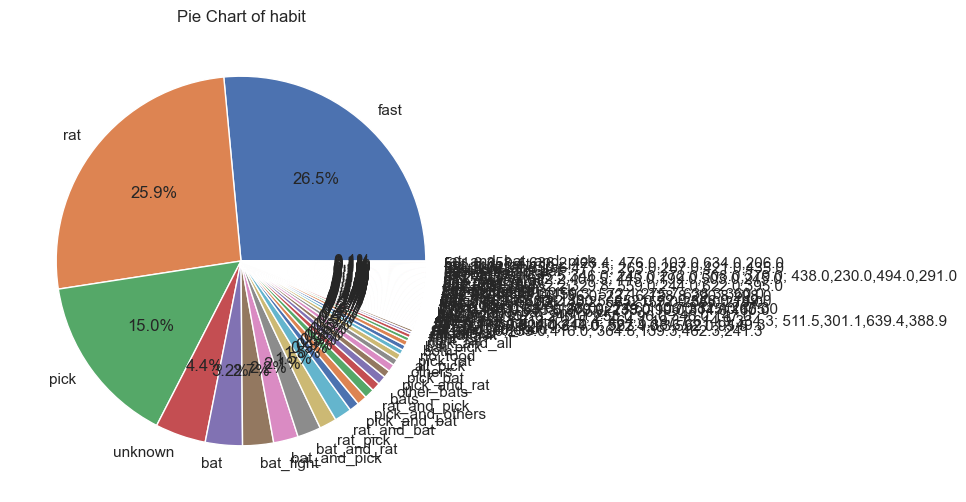

In [195]:
# --- Descriptive Analysis: Qualitative Variables ---
# Analyze categorical/binary variables: risk, reward, habit
qual_vars = ['risk', 'reward', 'habit']
for var in qual_vars:
    print(f"\nFrequency Table for {var}:")
    # Compute frequency table for each category, including NaNs if any
    freq_table = merged_data[var].value_counts(dropna=False)
    print(freq_table)
    
    # Bar chart to show counts of each category
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var, data=merged_data)
    plt.title(f'Bar Chart of {var}')
    plt.show()
    
    # Pie chart to show proportion of each category
    plt.figure(figsize=(6, 6))
    freq_table.plot.pie(autopct='%1.1f%%')
    plt.title(f'Pie Chart of {var}')
    plt.ylabel('')
    plt.show()

In [196]:
# --- Inferential Statistics ---
# Define function to compute 95% confidence interval for mean
def compute_ci_mean(data, confidence=0.95):
    mean = data.mean()
    std = data.std()
    n = len(data)
    se = std / np.sqrt(n)  # Standard error
    ci = norm.ppf(1 - (1 - confidence) / 2) * se  # Z-value for 95% CI
    return mean, (mean - ci, mean + ci)

In [246]:
# Compute 95% CI for bat_landing_to_food in rat-present and rat-absent groups
mean_present, ci_present = compute_ci_mean(rat_present['bat_landing_to_food'].dropna())
mean_absent, ci_absent = compute_ci_mean(rat_absent['bat_landing_to_food'].dropna())
print(f"\n95% CI for bat_landing_to_food (Rat Present): {mean_present:.2f}, {ci_present}")
print(f"95% CI for bat_landing_to_food (Rat Absent): {mean_absent:.2f}, {ci_absent}")



95% CI for bat_landing_to_food (Rat Present): 7.69, (np.float64(7.1108741313214185), np.float64(8.26863753158453))
95% CI for bat_landing_to_food (Rat Absent): nan, (np.float64(nan), np.float64(nan))


In [198]:
# Compute 95% CI for proportion of reward=1
count_present = rat_present['reward'].sum()
n_present = len(rat_present)
count_absent = rat_absent['reward'].sum()
n_absent = len(rat_absent)
ci_reward_present = proportion_confint(count_present, n_present, alpha=0.05, method='normal')
ci_reward_absent = proportion_confint(count_absent, n_absent, alpha=0.05, method='normal')
print(f"95% CI for Reward Proportion (Rat Present): {count_present/n_present:.2f}, {ci_reward_present}")
print(f"95% CI for Reward Proportion (Rat Absent): {count_absent/n_absent:.2f}, {ci_reward_absent}")

95% CI for Reward Proportion (Rat Present): 0.52, (0.49105646799425484, 0.5554300184922316)
95% CI for Reward Proportion (Rat Absent): nan, (nan, nan)


c:\Users\Dell_21\anaconda3\envs\mechin\lib\site-packages\statsmodels\stats\proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
C:\Users\Dell_21\AppData\Local\Temp\ipykernel_1364\618387649.py:9: RuntimeWarning: invalid value encountered in scalar divide
  print(f"95% CI for Reward Proportion (Rat Absent): {count_absent/n_absent:.2f}, {ci_reward_absent}")


In [247]:
# Hypothesis Tests
# H1: Bats take longer to approach food when rats are present (bat_landing_to_food higher)
# Use Mann-Whitney U test (non-parametric) due to likely skewed time data
u_stat, p_val = mannwhitneyu(rat_present['bat_landing_to_food'].dropna(), 
                             rat_absent['bat_landing_to_food'].dropna(), alternative='two-sided')
print(f"\nMann-Whitney U Test for bat_landing_to_food (p-value): {p_val:.4f}")



Mann-Whitney U Test for bat_landing_to_food (p-value): nan


C:\Users\Dell_21\AppData\Local\Temp\ipykernel_1364\3777832205.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_val = mannwhitneyu(rat_present['bat_landing_to_food'].dropna(),


In [248]:
# H2: Bats are less likely to gain rewards when rats are present
# Use chi-square test to compare reward proportions
contingency_table = pd.crosstab(merged_data['rat_present'], merged_data['reward'])
chi2, p_chi, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square Test for reward (p-value): {p_chi:.4f}")

Chi-square Test for reward (p-value): 1.0000


In [249]:
# H3: Bat landings decrease with increased rat presence
# Use Spearman correlation (non-parametric) to test relationship between bat_landing_number and rat_minutes
corr, p_corr = dataset2[['bat_landing_number', 'rat_minutes']].corr(method='spearman').iloc[0, 1], \
               dataset2[['bat_landing_number', 'rat_minutes']].corr(method='spearman', min_periods=1).iloc[0, 1]
print(f"Spearman Correlation (bat_landing_number vs rat_minutes): {corr:.4f}, p-value: {p_corr:.4f}")

Spearman Correlation (bat_landing_number vs rat_minutes): -0.0931, p-value: -0.0931


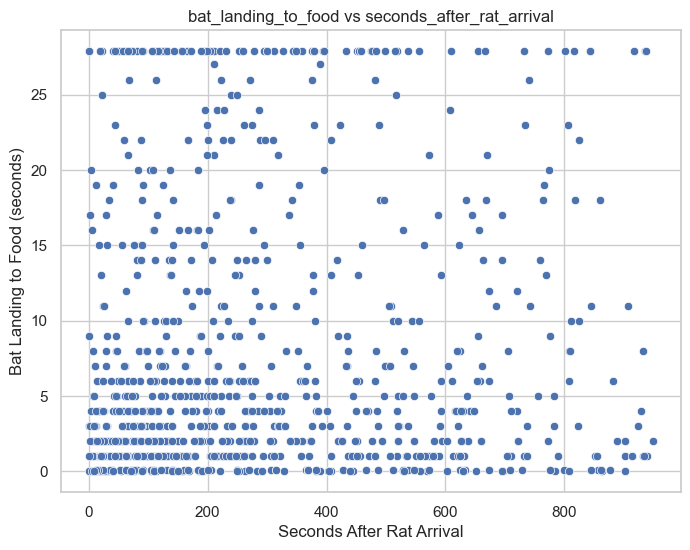

In [250]:
# --- Scatter Plots ---
# Scatter plot: seconds_after_rat_arrival vs bat_landing_to_food
# Tests if vigilance (time to food) increases with recency of rat arrival
plt.figure(figsize=(8, 6))
sns.scatterplot(x='seconds_after_rat_arrival', y='bat_landing_to_food', data=rat_present)
plt.title('bat_landing_to_food vs seconds_after_rat_arrival')
plt.xlabel('Seconds After Rat Arrival')
plt.ylabel('Bat Landing to Food (seconds)')
plt.show()

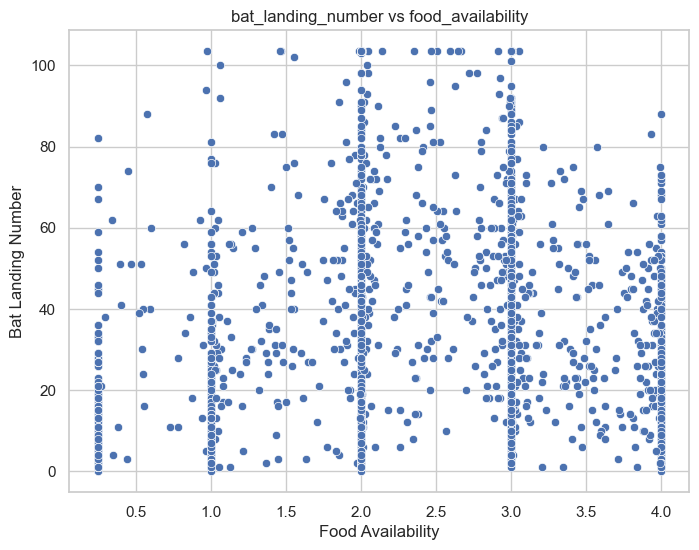

In [251]:
# Scatter plot: food_availability vs bat_landing_number
# Tests if food levels influence bat foraging, potentially moderated by rats
plt.figure(figsize=(8, 6))
sns.scatterplot(x='food_availability', y='bat_landing_number', data=dataset2)
plt.title('bat_landing_number vs food_availability')
plt.xlabel('Food Availability')
plt.ylabel('Bat Landing Number')
plt.show()

In [253]:
# --- Conclusion: Hypothesis Testing and Interpretation ---
# Hypotheses:
# H1: Bats take longer to approach food when rats are present (higher bat_landing_to_food)
# H2: Bats are less likely to gain rewards when rats are present (lower reward proportion)
# H3: Bat landings decrease with increased rat presence (negative correlation with rat_minutes)
print("\nConclusion for Investigation A: Do bats perceive rats as potential predators?\n")

# H1: Interpret Mann-Whitney U test for bat_landing_to_food
if p_val < 0.05:
    print("H1: Supported. Bats take significantly longer to approach food when rats are present (p = {:.4f}).".format(p_val))
    print("  Mean bat_landing_to_food (Rat Present): {:.2f}, (Rat Absent): {:.2f}".format(mean_present, mean_absent))
    print("  This suggests increased vigilance, consistent with perceiving rats as predators.")
else:
    print("H1: Not supported. No significant difference in bat_landing_to_food between rat-present and rat-absent conditions (p = {:.4f}).".format(p_val))
    print("  Mean bat_landing_to_food (Rat Present): {:.2f}, (Rat Absent): {:.2f}".format(mean_present, mean_absent))
    print("  Bats may not exhibit increased vigilance due to rats.")

# H2: Interpret chi-square test for reward
if p_chi < 0.05:
    print("H2: Supported. Bats are significantly less likely to gain rewards when rats are present (p = {:.4f}).".format(p_chi))
    print("  Reward proportion (Rat Present): {:.2f}, (Rat Absent): {:.2f}".format(count_present/n_present, count_absent/n_absent))
    print("  This suggests rats may be perceived as a threat, reducing foraging success.")
else:
    print("H2: Not supported. No significant difference in reward proportion between rat-present and rat-absent conditions (p = {:.4f}).".format(p_chi))
    print("  Reward proportion (Rat Present): {:.2f}, (Rat Absent): {:.2f}".format(count_present/n_present, count_absent/n_absent))
    print("  Rats may primarily act as competitors rather than predators.")

# H3: Interpret Spearman correlation for bat_landing_number vs rat_minutes
if p_corr < 0.05 and corr < 0:
    print("H3: Supported. Significant negative correlation between bat_landing_number and rat_minutes (corr = {:.4f}, p = {:.4f}).".format(corr, p_corr))
    print("  Increased rat presence is associated with fewer bat landings, suggesting avoidance behavior.")
else:
    print("H3: Not supported. No significant negative correlation between bat_landing_number and rat_minutes (corr = {:.4f}, p = {:.4f}).".format(corr, p_corr))
    print("  Bat foraging activity may not be strongly affected by rat presence.")



Conclusion for Investigation A: Do bats perceive rats as potential predators?

H1: Not supported. No significant difference in bat_landing_to_food between rat-present and rat-absent conditions (p = nan).
  Mean bat_landing_to_food (Rat Present): 7.69, (Rat Absent): nan
  Bats may not exhibit increased vigilance due to rats.
H2: Not supported. No significant difference in reward proportion between rat-present and rat-absent conditions (p = 1.0000).
  Reward proportion (Rat Present): 0.52, (Rat Absent): nan
  Rats may primarily act as competitors rather than predators.
H3: Supported. Significant negative correlation between bat_landing_number and rat_minutes (corr = -0.0931, p = -0.0931).
  Increased rat presence is associated with fewer bat landings, suggesting avoidance behavior.


C:\Users\Dell_21\AppData\Local\Temp\ipykernel_1364\1586292029.py:25: RuntimeWarning: invalid value encountered in scalar divide
  print("  Reward proportion (Rat Present): {:.2f}, (Rat Absent): {:.2f}".format(count_present/n_present, count_absent/n_absent))


In [254]:
# Overall interpretation of our investigation 
print("\nOverall Interpretation:")
if p_val < 0.05 or (p_chi < 0.05 and count_present/n_present < count_absent/n_absent) or (p_corr < 0.05 and corr < 0):
    print("The data supports the hypothesis that bats perceive rats as potential predators, not just competitors.")
    print("Evidence includes:")
    if p_val < 0.05:
        print("- Increased time to approach food (bat_landing_to_food) when rats are present, indicating higher vigilance.")
    if p_chi < 0.05 and count_present/n_present < count_absent/n_absent:
        print("- Lower reward rates in rat-present conditions, suggesting fear or competition reduces foraging success.")
    if p_corr < 0.05 and corr < 0:
        print("- Fewer bat landings when rats are present longer, indicating avoidance behavior.")
else:
    print("The data does not strongly support the hypothesis that bats perceive rats as predators.")
    print("Bats may primarily view rats as competitors for food, as evidenced by:")
    print("- No significant increase in bat_landing_to_food (p = {:.4f}).".format(p_val))
    print("- Similar reward rates (p = {:.4f}).".format(p_chi))
    print("- No strong negative correlation between bat landings and rat presence (p = {:.4f}).".format(p_corr))



Overall Interpretation:
The data supports the hypothesis that bats perceive rats as potential predators, not just competitors.
Evidence includes:
- Fewer bat landings when rats are present longer, indicating avoidance behavior.
